In [1]:
%load_ext autoreload
%autoreload 2
from metrics import generative_score

Add data loader and generator using pkl tomorrow
and test FID score!!!

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np

dataroot = "mnist_png/training"
image_size = 64
batch_size = 64
workers =1 

dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Grayscale(1),
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    # Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

In [3]:
import matplotlib.pyplot as plt
device = torch.device("cpu")
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
        np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [4]:
base_fid_statistics,inception_model= generative_score.initialize_fid(dataloader, sample_size=1000)

calculate base fid statistics
completed..


config.evolution.fitness.fid_dimension = 2048


This might be useful if the datasets you want to compare have less than the otherwise required 2048 images. Note that this changes the magnitude of the FID score and you can not compare them against scores calculated on another dimensionality. The resulting scores might also no longer correlate with visual quality.

You can select the dimensionality of features to use with the flag --dims N, where N is the dimensionality of features. The choices are:

64: first max pooling features
192: second max pooling featurs
768: pre-aux classifier features
2048: final average pooling features (this is the default)
License

In [6]:
from torch.autograd import Variable
for i, data in enumerate(dataloader, 0):
    input_shape = data[0].size()
    break

noise_size =  int(np.prod(input_shape[1:]))


def generate_noise(batch_size, volatile=False):
        with torch.set_grad_enabled(not volatile):
            gen_input = Variable(torch.randn(batch_size,noise_size))
            print(gen_input.size())
        return gen_input.view([batch_size] + list(input_shape[1:]))

allnoise = generate_noise(1000)
print(allnoise.size())

torch.Size([1000, 4096])
torch.Size([1000, 1, 64, 64])


In [8]:
nz=100
ngf =64
nc=1
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")
netG = Generator(1).to(device)
netG = torch.load('test.pkl')

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


torch.Size([3, 530, 530])


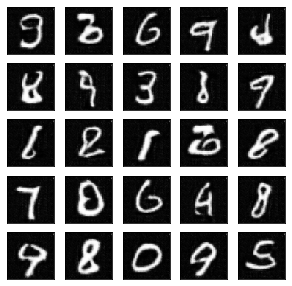

In [10]:
import itertools

# Test if generator is creating image
noise = torch.randn(64, 100, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise).detach().cpu()
imglist = vutils.make_grid(fake, padding=2, normalize=True)

print(imglist.size())
size_figure_grid = 5
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)

for k in range(5 * 5):
    i = k // 5
    j = k % 5
    ax[i, j].cla()
    ax[i, j].imshow(fake[k, 0].cpu().data.numpy(), cmap='gray')
plt.show()


In [ ]:
# for i, data in enumerate(dataloader, 0):
#     input_shape = data[0].size()
#     break

# print(input_shape)
# noise_size =  int(np.prod(input_shape[1:]))
# print(noise_size)

# def generate_noise(batch_size, volatile=False):
#         with torch.set_grad_enabled(not volatile):
#             gen_input = Variable(torch.randn(batch_size,noise_size))
#             print(gen_input.size())
#         return gen_input.view([batch_size] + list(input_shape[1:]))

# allnoise = generate_noise(1000)
# print(allnoise.size())

    

In [11]:
from metrics.fid import fid_score
from util import tools

noise = torch.randn(1000, 100, 1, 1, device=device)
netG.eval()
generated_images = netG(noise).detach()
inception_model = tools.cuda(inception_model)

In [12]:
m1, s1 = fid_score.calculate_activation_statistics(
        generated_images.data.cpu().numpy(), inception_model, cuda=tools.is_cuda_available(),
        dims=2048)
inception_model.cpu()
m2, s2 = base_fid_statistics

In [13]:
ret = fid_score.calculate_frechet_distance(m1, s1, m2, s2)
netG.zero_grad()
print(ret)


67.16924451541911
